## TinyNet: The Anatomy of a Tiny Neural Network 

### The Architecture: 4-3-2

We are training a minimalist Multi-Layer Perceptron (MLP). By stripping away the complexity of thousands of nodes, we can witness the math in high definition:

1. **Input Layer (4 Nodes)**: Representing a tiny 2 × 2 pixel world. Each pixel has varying levels of brightness. Brightest is 1.0 and Darkest is 0.0.

2. **Hidden Layer (3 Nodes)**: The "internal representation" where the model attempts to find patterns. Each neuron learns to detect different features in the input.

3. **Output Layer (2 Nodes)**: The decision layer. The first node represents "Horizontal" confidence, the second represents "Vertical" confidence.

### What You'll Learn

By the end of this notebook, you'll understand:
- How neural networks initialize with random weights
- What a single backpropagation step does (the "nudge")
- How training reduces loss over many epochs
- Why simple models fail on real-world data (overfitting)
- What convergence looks like mathematically

Let's dive in!

### Part 1: Setting Up The Lab

Let's start by checking that your environment is ready for neural network training.

In [ ]:
# Install the essential libraries for this project
%pip install torch torchvision matplotlib seaborn

In [ ]:
import torch
import sys
import platform

# 1. System Info
print(f"OS: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"Python Version: {sys.version.split()[0]}")

# 2. PyTorch Info
print(f"\nPyTorch Version: {torch.__version__}")

# 3. Hardware Acceleration Check
if torch.backends.mps.is_available():
    print("MPS (Metal Performance Shaders) is AVAILABLE.")
    print("Your GPU is ready to accelerate these gradients!")
    device = torch.device("mps")
else:
    print("MPS not found. Using CPU.")
    device = torch.device("cpu")

# 4. Device Info
# Note: On M4, this is Unified Memory shared with the system
print(f"Device being used: {device}")

### Part 2: The Architecture (4-3-2)

#### Visualization

Before we dive into training, let's visualize what this 4→3→2 architecture actually looks like. Each line represents a weight parameter, and each node has an associated bias.

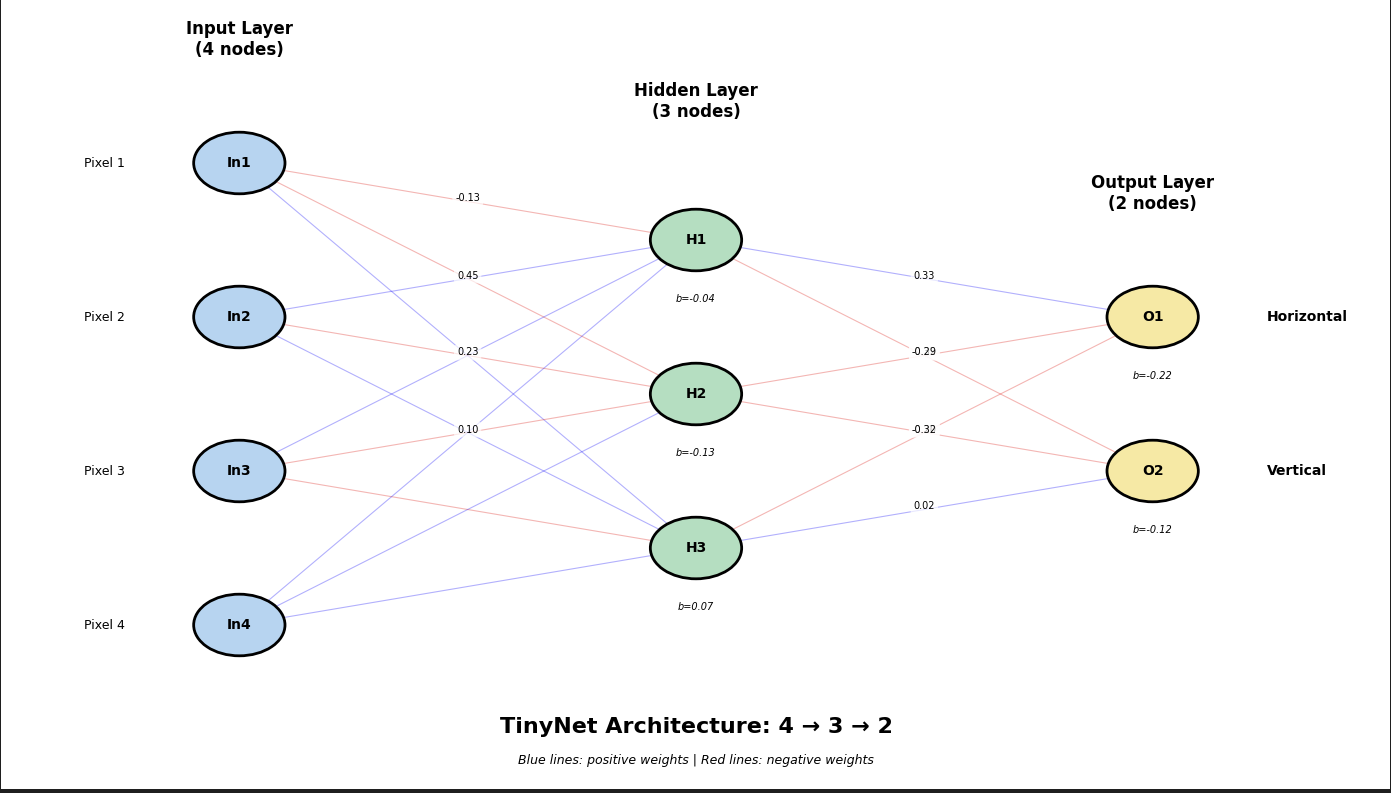


Let's create a simple 3-layer architecture where each layer transforms the data to eventually classify horizontal vs vertical lines.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class TinyNet(nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        # Layer 1: 4 inputs -> 3 hidden neurons
        # This creates a weight matrix of shape [3, 4] and bias vector of shape [3]
        self.layer1 = nn.Linear(4, 3) 
        
        # Layer 2: 3 hidden -> 2 output neurons
        # Weight matrix shape [2, 3] and bias vector shape [2]
        self.layer2 = nn.Linear(3, 2)
        
        # Sigmoid activation: squashes any value to the range [0, 1]
        # Formula: σ(x) = 1 / (1 + e^(-x))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass: input -> layer1 -> sigmoid -> layer2 -> sigmoid -> output
        x = self.sigmoid(self.layer1(x))  # Hidden layer activations
        x = self.sigmoid(self.layer2(x))  # Output layer activations
        return x

model = TinyNet()
print("Model initialized!")

### Visualizing Our Training Data

Let's see what our 4 training examples actually look like as 2x2 pixel grids. Each input is a flattened array of 4 numbers representing pixels in [Top-Left, Top-Right, Bottom-Left, Bottom-Right] order.

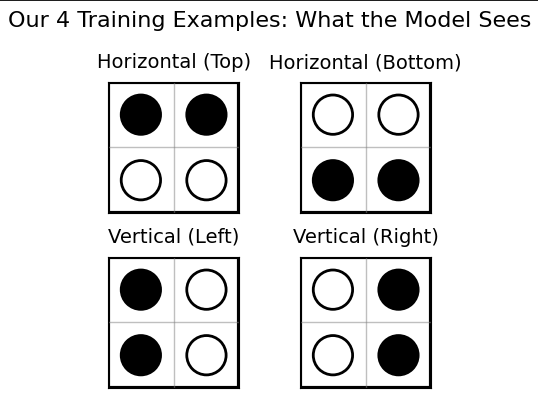

### Part 3: The First Nudge

#### Data peeking

The model is initialized with random weights and biases. Let's take a peek first and reimagine the architecture diagram above with these numbers. That's the current/init state of your model before ANY training.

In [ ]:
# Let's peek at the weights and biases of the first layer
print("--- Layer 1: Weights (4 inputs connecting to 3 hidden nodes) ---")
# The weight matrix is 3x4 because it's [output_nodes, input_nodes]
print(model.layer1.weight.data)

print("\n--- Layer 1: Biases (One for each of the 3 hidden nodes) ---")
print(model.layer1.bias.data)

print("\n--- Layer 2: Weights (3 hidden nodes connecting to 2 output nodes) ---")
print(model.layer2.weight.data)

#### The first run

we want to see the output of our model for a single run, so we need to feed it a single input and get the output. Since we start with random weights and biases, the output is definitely going to be "off the mark" so the backpropagation nudges the weights and biases in a direction it sees fit.

Go ahead and run this cell multiple times, you'll see the tensor values change and more importantly the `Current Loss` value go down as the model learns.



In [ ]:
# --- 1. CAPTURE THE 'BEFORE' STATE ---
w1_before = model.layer1.weight.data.clone()
b1_before = model.layer1.bias.data.clone()

# --- The Judge and the Adjuster ---
# MSE Loss: measures the squared difference between prediction and target
# Formula: MSE = (1/n) * Σ(predicted - actual)²
criterion = torch.nn.MSELoss()

# SGD Optimizer: Stochastic Gradient Descent with learning rate 0.1
# The learning rate controls how big each "nudge" is
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# --- 2. THE NUDGE ---
input_data = torch.tensor([1.0, 1.0, 0.0, 0.0])  # Horizontal Line (top row bright)
target = torch.tensor([1.0, 0.0])                # Correct Answer: [Horizontal, Vertical]

# Forward pass: run the input through the network
output = model(input_data)

# Calculate the loss: how wrong is our prediction?
loss = criterion(output, target)

# Backpropagation: compute gradients for all weights
# This uses the chain rule to figure out how each weight contributed to the error
optimizer.zero_grad()  # Clear any previous gradients
loss.backward()         # Compute gradients via backpropagation

# Update weights: move each weight in the direction that reduces loss
# New weight = Old weight - (learning_rate * gradient)
optimizer.step()

# --- 3. PRETTY PRINT THE ENTIRE LAYER 1 ---
print("=== TINYNET: LAYER 1 EVOLUTION ===")
print(f"Current Loss: {loss.item():.6f}\n")

print("--- BIASES (The 3 Hidden Nodes) ---")
print(f"Before: {b1_before}")
print(f"After:  {model.layer1.bias.data}")
print(f"Change: {model.layer1.bias.data - b1_before}")

print("\n--- WEIGHT MATRIX (3 rows x 4 columns) ---")
for i in range(len(w1_before)):
    print(f"\nHidden Node {i} Weights:")
    print(f"  Before: {w1_before[i]}")
    print(f"  After:  {model.layer1.weight.data[i]}")
    print(f"  Change: {model.layer1.weight.data[i] - w1_before[i]}")

### Part 4: Full Training (100 Epochs)

Instead of training "by hand" and running the cell over and over again, let's train on all 4 examples for 100 complete passes (epochs). We'll watch the loss decrease as the model learns.

In [ ]:
import matplotlib.pyplot as plt

# Reinitialize model for clean 100-epoch training
model = TinyNet()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 1. Define our tiny world (Horizontal vs Vertical)
# Each input is [Top-Left, Top-Right, Bottom-Left, Bottom-Right]
# Each target is [Horizontal confidence, Vertical confidence]
data = [
    (torch.tensor([1.0, 1.0, 0.0, 0.0]), torch.tensor([1.0, 0.0])), # Horizontal top
    (torch.tensor([0.0, 0.0, 1.0, 1.0]), torch.tensor([1.0, 0.0])), # Horizontal bottom
    (torch.tensor([1.0, 0.0, 1.0, 0.0]), torch.tensor([0.0, 1.0])), # Vertical left
    (torch.tensor([0.0, 1.0, 0.0, 1.0]), torch.tensor([0.0, 1.0]))  # Vertical right
]

loss_history = []

# 2. The Training Loop (100 Epochs)
# An "epoch" is one complete pass through all training examples
print("Training started...")
for epoch in range(100):
    epoch_loss = 0
    
    # Train on each of the 4 examples
    for input_pixels, label in data:
        # Forward Pass: make a prediction
        output = model(input_pixels)
        
        # Calculate loss: how wrong is the prediction?
        loss = criterion(output, label)
        
        # Backprop: compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss for this epoch
        epoch_loss += loss.item()
    
    # Store average loss for this epoch
    loss_history.append(epoch_loss / len(data))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Average Loss: {loss_history[-1]:.4f}")

print(f"\nTraining complete! Final loss: {loss_history[-1]:.4f}")

# 3. Graph the Progress
plt.plot(loss_history)
plt.title("TinyNet Learning Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss (Error)")
plt.grid(True)
plt.show()

### Testing on Training Data

After 100 epochs of training, let's verify that the model actually learned the 4 training examples. This should show high confidence on each pattern.

In [ ]:
# Test the trained model on the original 4 training examples
print("=== TRAINING DATA ACCURACY ===")
model.eval()
with torch.no_grad():
    for pixels, name in [
        (torch.tensor([1.0, 1.0, 0.0, 0.0]), "Horizontal (top)"),
        (torch.tensor([0.0, 0.0, 1.0, 1.0]), "Horizontal (bottom)"),
        (torch.tensor([1.0, 0.0, 1.0, 0.0]), "Vertical (left)"),
        (torch.tensor([0.0, 1.0, 0.0, 1.0]), "Vertical (right)")
    ]:
        pred = model(pixels)
        h_conf, v_conf = pred[0].item() * 100, pred[1].item() * 100
        print(f"{name:20} | H: {h_conf:5.1f}% | V: {v_conf:5.1f}%")

print("\n✓ Success! The model nails every training example.")
print("But wait... let's see how it handles cases it has NEVER seen before...")

### Understanding Convergence: Why Do The Nudges Get Smaller?

You might have noticed that the loss decreases quickly at first, then slows down. Let's visualize what's happening to the weights themselves as the model learns. We'll track how much the weights change (the "nudge") with each epoch and compare it to the loss.

In [ ]:
# Reinitialize model to demonstrate convergence from scratch
model = TinyNet()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define training data
data = [
    (torch.tensor([1.0, 1.0, 0.0, 0.0]), torch.tensor([1.0, 0.0])),
    (torch.tensor([0.0, 0.0, 1.0, 1.0]), torch.tensor([1.0, 0.0])),
    (torch.tensor([1.0, 0.0, 1.0, 0.0]), torch.tensor([0.0, 1.0])),
    (torch.tensor([0.0, 1.0, 0.0, 1.0]), torch.tensor([0.0, 1.0]))
]

loss_history = []
weight_movements = []

# Training loop with weight tracking
for epoch in range(100):
    # Capture weights BEFORE the epoch
    w_start = model.layer1.weight.data.clone()
    
    epoch_loss = 0
    for x, y in data:
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Calculate how much the weights moved
    # torch.norm computes the total magnitude of change across all weights
    delta = torch.norm(model.layer1.weight.data - w_start).item()
    
    loss_history.append(epoch_loss / len(data))
    weight_movements.append(delta)

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss on left axis
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss (The Judge)', color=color)
ax1.plot(loss_history, color=color, linewidth=2, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

# Plot Weight Movement on right axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Weight Movement (The Nudge)', color=color)
ax2.plot(weight_movements, color=color, linestyle='--', label="Weight Delta")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Convergence: As Loss Decreases, Weight Changes Get Smaller")
fig.tight_layout()
plt.show()

print("Notice: As the model gets closer to the right answer, the gradients get smaller,")
print("so the weight updates (nudges) also get smaller. This is convergence in action!")

### Part 5: Testing on Fuzzy Data

One thing to note is that our training data was perfect (1.0 or 0.0). But what happens when we test with realistic, noisy data?

In [ ]:
# The "Fuzzy" Line Test
# Our training data was perfect: 1.0 or 0.0, nothing in between
# But real-world data is messy. Let's test with "fuzzy" pixels around 90% and 10% brightness
fuzzy_horizontal = torch.tensor([0.8888, 0.9, 0.1112, 0.1]) 

# Put model in evaluation mode (disables training-specific behavior like dropout)
model.eval()

# Run inference without tracking gradients (faster, uses less memory)
with torch.no_grad():
    prediction = model(fuzzy_horizontal)

print(f"Input Data: {fuzzy_horizontal}")
print(f"Confidence - Horizontal: {prediction[0]:.2%}")
print(f"Confidence - Vertical:   {prediction[1]:.2%}")
print("\nNotice: The model is uncertain! This is a hint of problems to come...")

### Part 6: Visualizing What The Model Learned

Let's peek inside the hidden layer to see what patterns each neuron has learned to detect.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract weights from the first layer
# Each of the 3 hidden nodes has 4 weights (one per input pixel)
weights = model.layer1.weight.data.numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('What TinyNet\'s 3 Hidden Nodes are "Looking For"', fontsize=16)

for i in range(3):
    # Reshape the 4 weights back into a 2x2 grid to visualize them spatially
    # Positive weights (red) mean "activates when pixel is bright"
    # Negative weights (blue) mean "activates when pixel is dark"
    sns.heatmap(weights[i].reshape(2, 2), annot=True, ax=axes[i], cmap="coolwarm", center=0)
    axes[i].set_title(f"Hidden Node {i}")

plt.show()

print("\nInterpretation:")
print("- Red values: node fires when that pixel is BRIGHT")
print("- Blue values: node fires when that pixel is DARK")
print("- Each hidden node learns to detect different patterns in the 2x2 grid")

### Part 7: The Stress Test - Where It All Falls Apart

Time for the moment of truth. Let's test the model on cases it has never seen before: single pixels, uniform blocks, and diagonals.

In [ ]:
# 1. Define 'Unseen' Stress Test Cases
# [Top-L, Top-R, Bot-L, Bot-R]
stress_data = [
    (torch.tensor([1.0, 0.0, 0.0, 0.0]), "Single Pixel (Top-L)"), 
    (torch.tensor([0.5, 0.5, 0.5, 0.5]), "Solid Gray Block"),
    (torch.tensor([0.0, 1.0, 1.0, 0.0]), "Diagonal Line /"),
    (torch.tensor([1.0, 0.0, 0.0, 1.0]), "Diagonal Line \\")
]

print("=== TINYNET STRESS TEST ===")
model.eval()
with torch.no_grad():
    for pixels, name in stress_data:
        pred = model(pixels)
        h_conf, v_conf = pred[0].item() * 100, pred[1].item() * 100
        winner = "HORIZONTAL" if h_conf > v_conf else "VERTICAL"
        print(f"{name:20} | H: {h_conf:4.1f}% | V: {v_conf:4.1f}% | Winner: {winner}")

The Stress Test results look interesting. The model isn't correct or not confident enough. What if we crank up the learning rate?

In [ ]:
# Reinitialize model from scratch
model_aggressive = TinyNet()
criterion = nn.MSELoss()

# THIS TIME: Learning rate = 5.0 (50x larger!)
optimizer_aggressive = torch.optim.SGD(model_aggressive.parameters(), lr=5.0)

# Training data (same as before)
data = [
    (torch.tensor([1.0, 1.0, 0.0, 0.0]), torch.tensor([1.0, 0.0])),
    (torch.tensor([0.0, 0.0, 1.0, 1.0]), torch.tensor([1.0, 0.0])),
    (torch.tensor([1.0, 0.0, 1.0, 0.0]), torch.tensor([0.0, 1.0])),
    (torch.tensor([0.0, 1.0, 0.0, 1.0]), torch.tensor([0.0, 1.0]))
]

loss_history_aggressive = []

print("Training with lr=5.0...")
for epoch in range(100):
    epoch_loss = 0
    
    for input_pixels, label in data:
        output = model_aggressive(input_pixels)
        loss = criterion(output, label)
        
        optimizer_aggressive.zero_grad()
        loss.backward()
        optimizer_aggressive.step()
        
        epoch_loss += loss.item()
    
    loss_history_aggressive.append(epoch_loss / len(data))
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Average Loss: {loss_history_aggressive[-1]:.6f}")

print(f"\nFinal loss: {loss_history_aggressive[-1]:.6f}")

print("\nTest on the training data..")

In [ ]:
# Test on the training data
print("=== TRAINING DATA ACCURACY (lr=5.0) ===")
model_aggressive.eval()
with torch.no_grad():
    for pixels, name in [
        (torch.tensor([1.0, 1.0, 0.0, 0.0]), "Horizontal (top)"),
        (torch.tensor([0.0, 0.0, 1.0, 1.0]), "Horizontal (bottom)"),
        (torch.tensor([1.0, 0.0, 1.0, 0.0]), "Vertical (left)"),
        (torch.tensor([0.0, 1.0, 0.0, 1.0]), "Vertical (right)")
    ]:
        pred = model_aggressive(pixels)
        h_conf, v_conf = pred[0].item() * 100, pred[1].item() * 100
        print(f"{name:20} | H: {h_conf:5.1f}% | V: {v_conf:5.1f}%")

print("\nLooks great! The model is super confident on the training data. Now let's check the stress test...")

In [ ]:
# 1. Define 'Unseen' Stress Test Cases
# [Top-L, Top-R, Bot-L, Bot-R]
stress_data = [
    (torch.tensor([1.0, 0.0, 0.0, 0.0]), "Single Pixel (Top-L)"), 
    (torch.tensor([0.5, 0.5, 0.5, 0.5]), "Solid Gray Block"),
    (torch.tensor([0.0, 1.0, 1.0, 0.0]), "Diagonal Line /"),
    (torch.tensor([1.0, 0.0, 0.0, 1.0]), "Diagonal Line \\")
]

# Stress test with lr=5.0 model
print("=== STRESS TEST WITH lr=5.0 ===")
model_aggressive.eval()
with torch.no_grad():
    for pixels, name in stress_data:
        pred = model_aggressive(pixels)
        h_conf, v_conf = pred[0].item() * 100, pred[1].item() * 100
        winner = "HORIZONTAL" if h_conf > v_conf else "VERTICAL"
        print(f"{name:20} | H: {h_conf:4.1f}% | V: {v_conf:4.1f}% | Winner: {winner}")

### The Aha Moment: Confidence ≠ Correctness

This is still not quite right. At this point, you need to realize that it's not the modeling or the learning rate or anything else that's wrong. It's the modeling data itself!

**Being uncertain is not a weakness.** When the input is ambiguous, uncertainty is the correct response. A model that confidently declares a gray block is `VERTICAL` or `HORIZONTAL` hasn't learned the concept—it's just memorized patterns with extreme weights.

This is why hyperparameter tuning matters: not just for training speed, but for model behavior and reliability.

### Next Steps: From Discovery to Training

**The story doesn't end here.**

To build a model that actually generalizes and works well, we need to level up!

Continue to the **Trainer Runbook** where we'll implement these improvements and build a model that actually works on ambiguous cases. You'll see the difference between a memorizer and a true learner.

### Learning Resources

If you're new to neural networks, here are some excellent resources to complement this notebook:

- **3Blue1Brown's Neural Network Series**: The visual masterclass that inspired this project. [Watch on YouTube](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
- **PyTorch Tutorials**: Official documentation and beginner guides. [PyTorch.org/tutorials](https://pytorch.org/tutorials/)
- **Key Concepts**:
  - **Backpropagation**: How neural networks learn by adjusting weights based on errors
  - **Gradient Descent**: The optimization algorithm that "nudges" weights in the right direction  
  - **Activation Functions**: Functions like Sigmoid that introduce non-linearity into the network